<a href="https://colab.research.google.com/github/Kgsanderson93/PowerUpProject/blob/main/src/422Powerup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install ipython-autotime
%load_ext autotime
import os


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.41 s (started: 2024-01-23 14:36:50 +00:00)


In [22]:
!git clone https://github.com/Kgsanderson93/PowerUpProject.git


fatal: destination path 'PowerUpProject' already exists and is not an empty directory.
time: 108 ms (started: 2024-01-23 14:36:58 +00:00)


time: 114 ms (started: 2024-01-23 14:36:58 +00:00)


In [23]:
import timeit

time: 750 µs (started: 2024-01-23 14:36:59 +00:00)


In [24]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('seaborn')

from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm
from pmdarima.utils import tsdisplay
from scipy.stats import normaltest


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

errorcmp=pd.DataFrame(columns=['Name', 'MSE', 'MAE', 'MAPE', 'Elapsed_Time'])
def modelcmp(m1,m2):
  MSE=np.sqrt(mean_squared_error(y_true=m1,
                   y_pred=m2))
  MAE=mean_absolute_error(y_true=m1,
                   y_pred=m2)
  MAPE=mean_absolute_percentage_error(y_true=m1,
                   y_pred=m2)
  return MSE, MAE, MAPE


time: 12.6 s (started: 2024-01-23 14:36:59 +00:00)


In [25]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[[label]]
        return X, y
    return X



time: 5.35 ms (started: 2024-01-23 14:37:11 +00:00)


In [26]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 is divisible by 7, so the lagged days of the week line up with the days fo the week
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df



time: 813 µs (started: 2024-01-23 14:37:11 +00:00)


In [27]:
def createdf():
  return (pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0]))

time: 2.65 ms (started: 2024-01-23 14:37:11 +00:00)


In [28]:
def split_data(outlier, lags=False):


  df =createdf()
  if lags==True:
    df=add_lags(df)
  if outlier==True:
    df = df.loc[df['PJME_MW'] > 19500].copy()
  tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, max_train_size=24*365*1)
  df = df.sort_index() # df needs to be sorted for TimeSeriesSplit
  ig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)
  fold = 0
  train_set=[]
  test_set=[]
  for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train_set.append(train)
    test_set.append(test)
    train['PJME_MW'].plot(ax=axes[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}')

    test['PJME_MW'].plot(ax=axes[fold],
                         label='Test Set')

    axes[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1
  train_x_set=[]
  train_y_set=[]
  test_x_set=[]
  test_y_set=[]
  for i in train_set:
    X, y = create_features(i, label='PJME_MW')
    train_x_set.append(X)
    train_y_set.append(y)
    features_and_target = pd.concat([X, y], axis=1)

  for i in test_set:
    X, y = create_features(i, label='PJME_MW')
    test_x_set.append(X)
    test_y_set.append(y)
    features_and_target = pd.concat([X, y], axis=1)
  return (train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set)

time: 3.27 ms (started: 2024-01-23 14:37:11 +00:00)


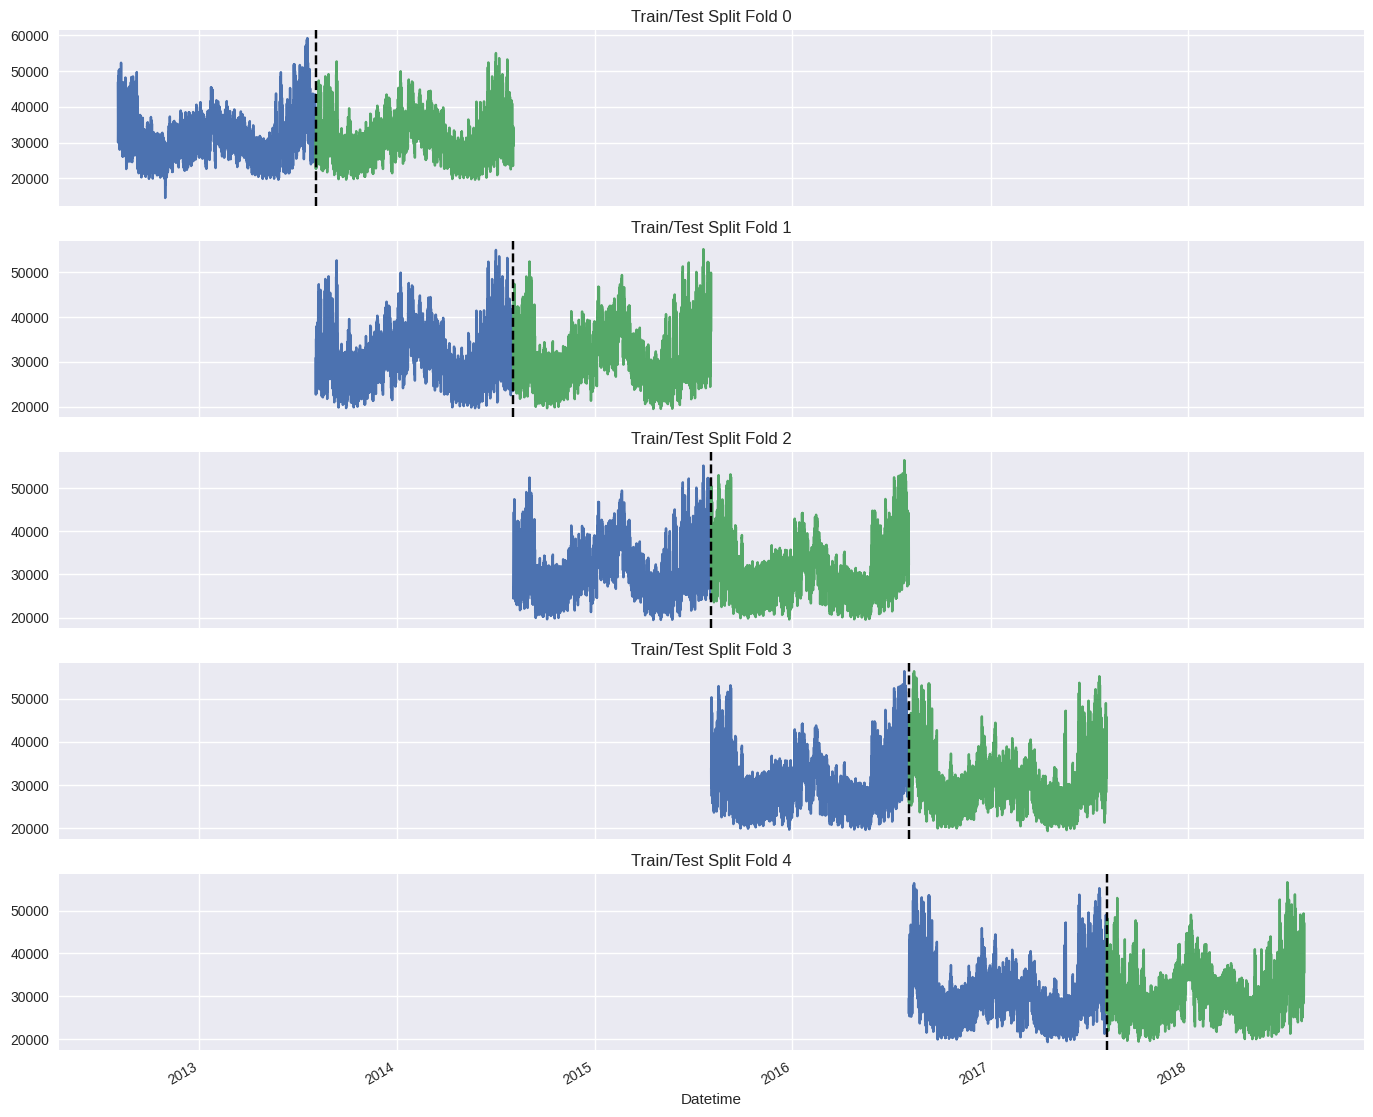

time: 14.8 s (started: 2024-01-23 14:37:11 +00:00)


In [29]:
train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set=split_data(False, lags=True)


In [32]:
def data_explore():
  df= pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
  color_pal = sns.color_palette()
  df.plot(style='.',
          figsize=(18, 8),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
  plt.show()
  fig, ax = plt.subplots(figsize=(20, 8))
  features, target=create_features(df, label="PJME_MW")
  features["PJME_MW"]=target["PJME_MW"]
  sns.boxplot(data=features.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)

  ax.set_title('Power Use MW by Day of Week')
  ax.set_xlabel('Day of Week')
  ax.set_ylabel('Energy (MW)')
  ax.legend(bbox_to_anchor=(1, 1))

  plt.show()

  import math
  avg = df['PJME_MW'].mean()
  stdev = math.sqrt(((df['PJME_MW'] - avg)**2).sum() / len(df))

  df['PJME_MW'].hist(bins=100)

  # Plot the 3rd standard deviation on the histogram
  plt.axvline(avg + stdev*3, color='black')
  plt.axvline(avg - stdev*3, color='black')

  plt.show()
  fig, ax = plt.subplots(figsize=(15, 8))
  graph = sns.boxplot(data=features, x='hour', y='PJME_MW')
  ax.set_title('MW by Hour')
  graph.axhline(df['PJME_MW'].quantile(0.95))
  graph.axhline(df['PJME_MW'].quantile(0.05))
  plt.show()
  fig, ax = plt.subplots(figsize=(15, 8))
  graph = sns.boxplot(data=features, x='month', y='PJME_MW')
  ax.set_title('MW by Month')
  plt.axhline(avg + stdev*3, color='black')
  plt.axhline(avg - stdev*3, color='black')
  plt.show()
  #Determine rolling statistics
  df["rolling_avg_12hour"] = df['PJME_MW'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
  df["rolling_std_12hour"] = df['PJME_MW'].rolling(window=12).std()
  df["rolling_avg_daily"] = df['PJME_MW'].rolling(window=24).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
  df["rolling_std_daily"] = df['PJME_MW'].rolling(window=24).std()
  df["rolling_avg_weekly"] = df['PJME_MW'].rolling(window=168).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
  df["rolling_std_weekly"] = df['PJME_MW'].rolling(window=168).std()
  df["rolling_avg_monthly"] = df['PJME_MW'].rolling(window=744).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
  df["rolling_std_monthly"] = df['PJME_MW'].rolling(window=744).std()
  df["rolling_avg_yearly"] = df['PJME_MW'].rolling(window=8760).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
  df["rolling_std_yearly"] = df['PJME_MW'].rolling(window=8760).std()
  plt.figure(figsize=(15,7))
  plt.plot(df['PJME_MW'], color='#379BDB', label='Original')
  plt.plot(df["rolling_avg_12hour"], color='darkviolet', label='Rolling Mean 12hour')
  plt.plot(df["rolling_std_12hour"], color='darkorchid', label='Rolling Std_12hour')
  plt.plot(df["rolling_avg_daily"], color='#D22A0D', label='Rolling Mean Daily')
  plt.plot(df["rolling_std_daily"], color='#142039', label='Rolling Std Daily')
  plt.plot(df["rolling_avg_weekly"], color='#D67A0D', label='Rolling Mean Weekly')
  plt.plot(df["rolling_std_weekly"], color='#167039', label='Rolling Std Weekly')
  plt.plot(df["rolling_avg_monthly"], color='darkgreen', label='Rolling Mean Monthly')
  plt.plot(df["rolling_std_monthly"], color='green', label='Rolling Std Monthly')
  plt.plot(df["rolling_avg_yearly"], color='gold', label='Rolling Mean Yearly')
  plt.plot(df["rolling_std_yearly"], color='yellow', label='Rolling Std Yearly')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  #Augmented Dickey–Fuller test:
  print('Results of Dickey Fuller Test:')
  dftest = adfuller(df['PJME_MW'], autolag='AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)


time: 3.93 ms (started: 2024-01-23 14:38:34 +00:00)


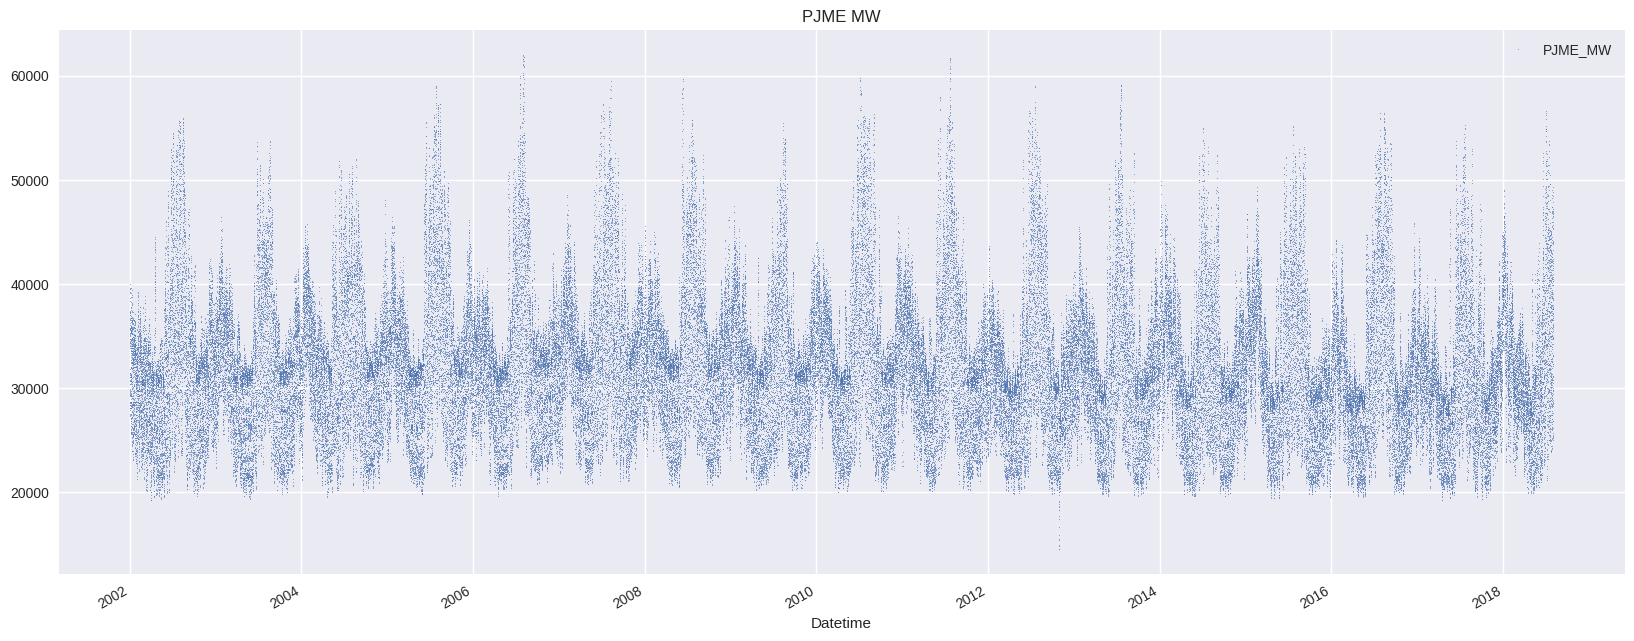

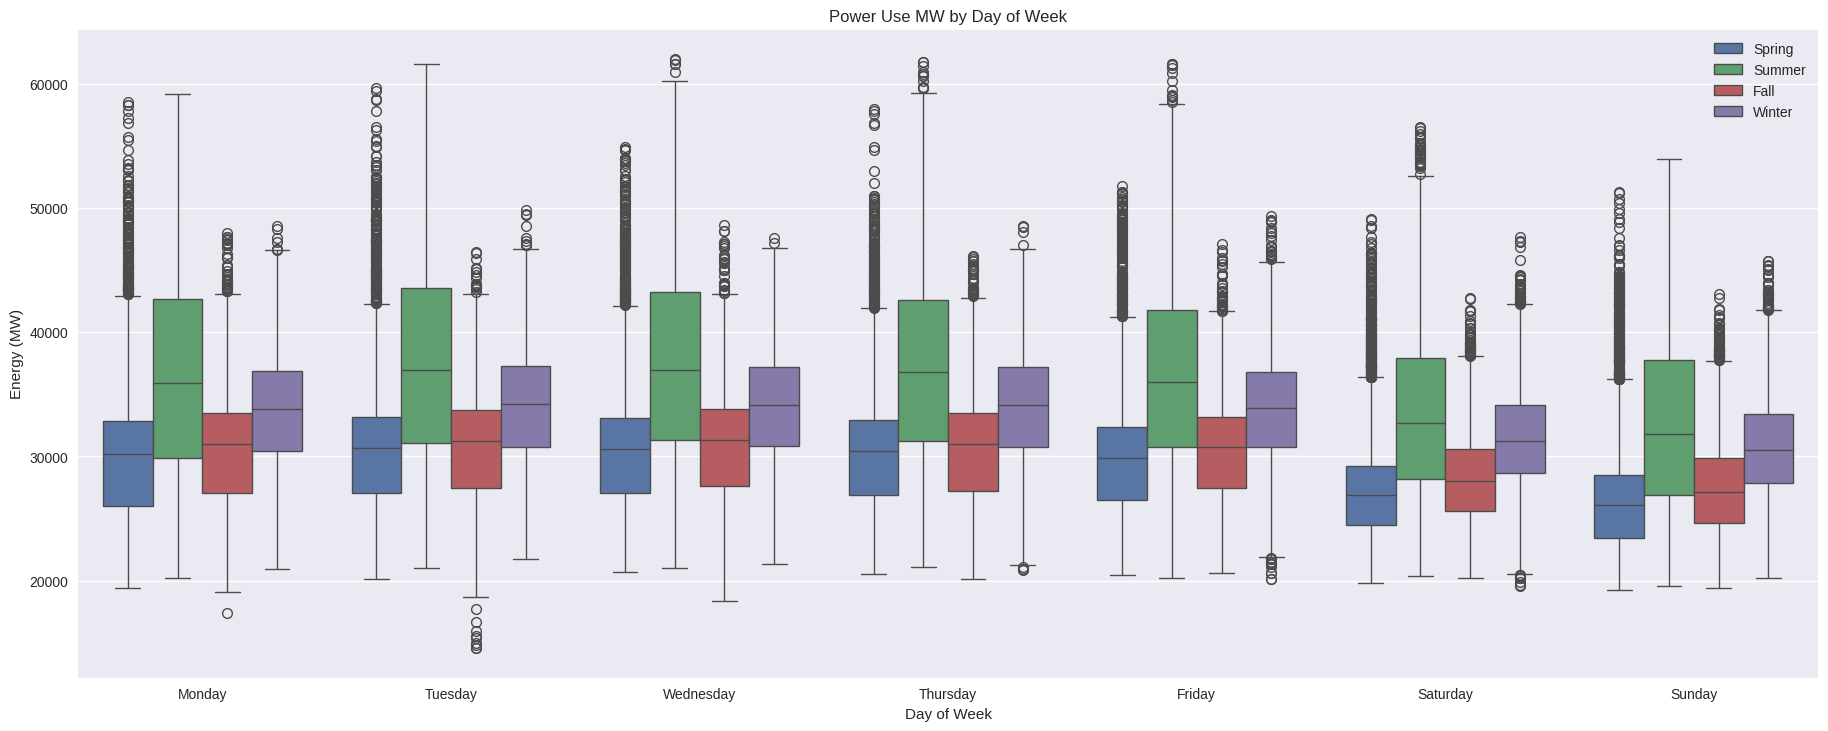

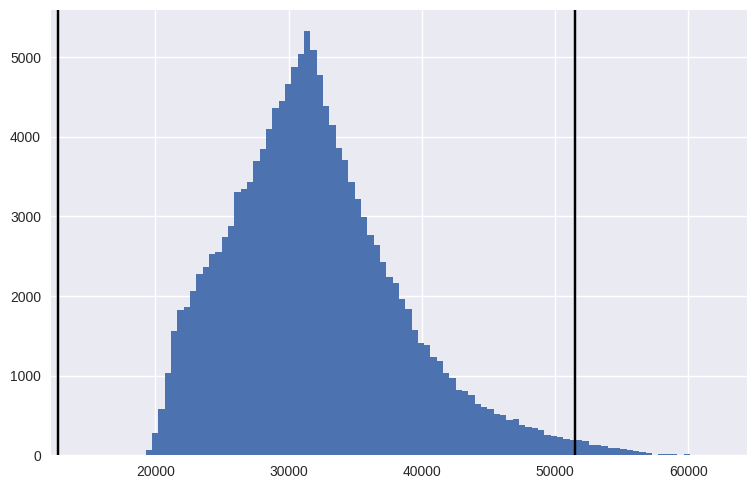

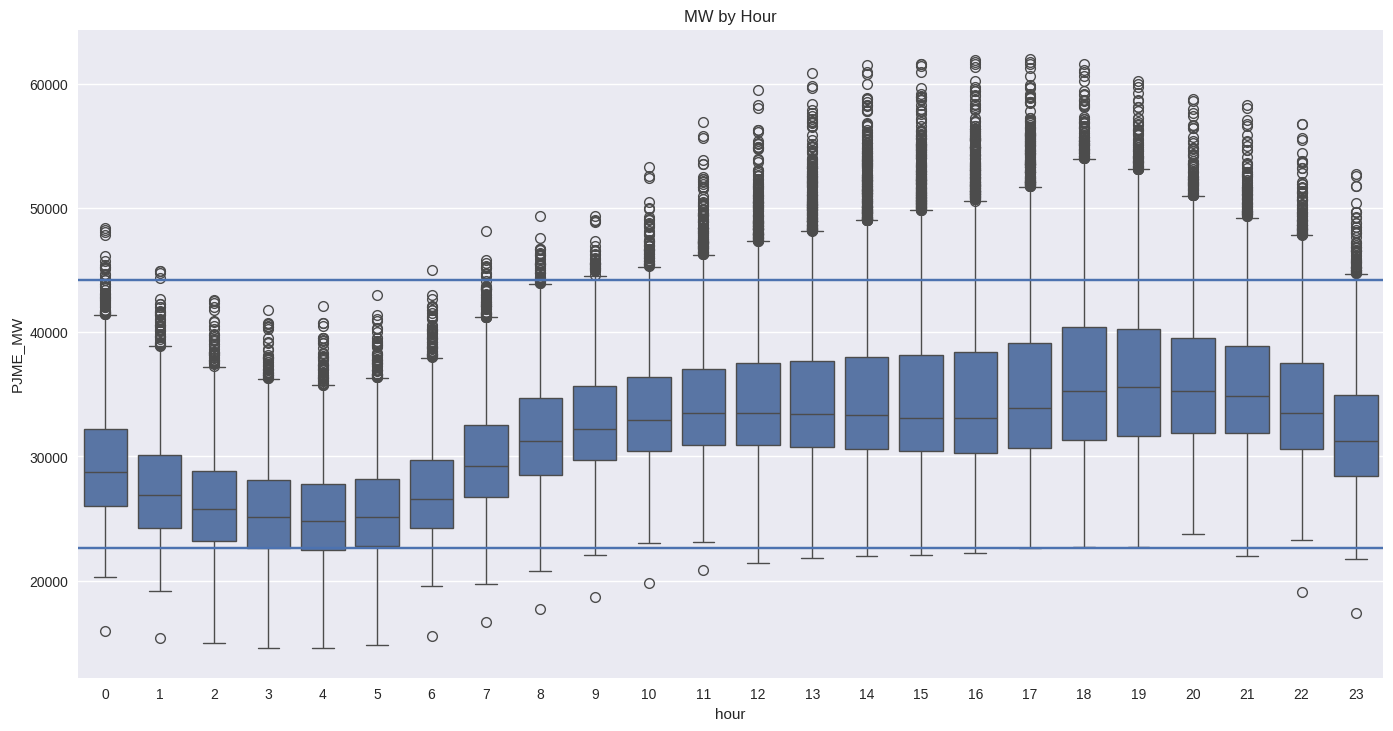

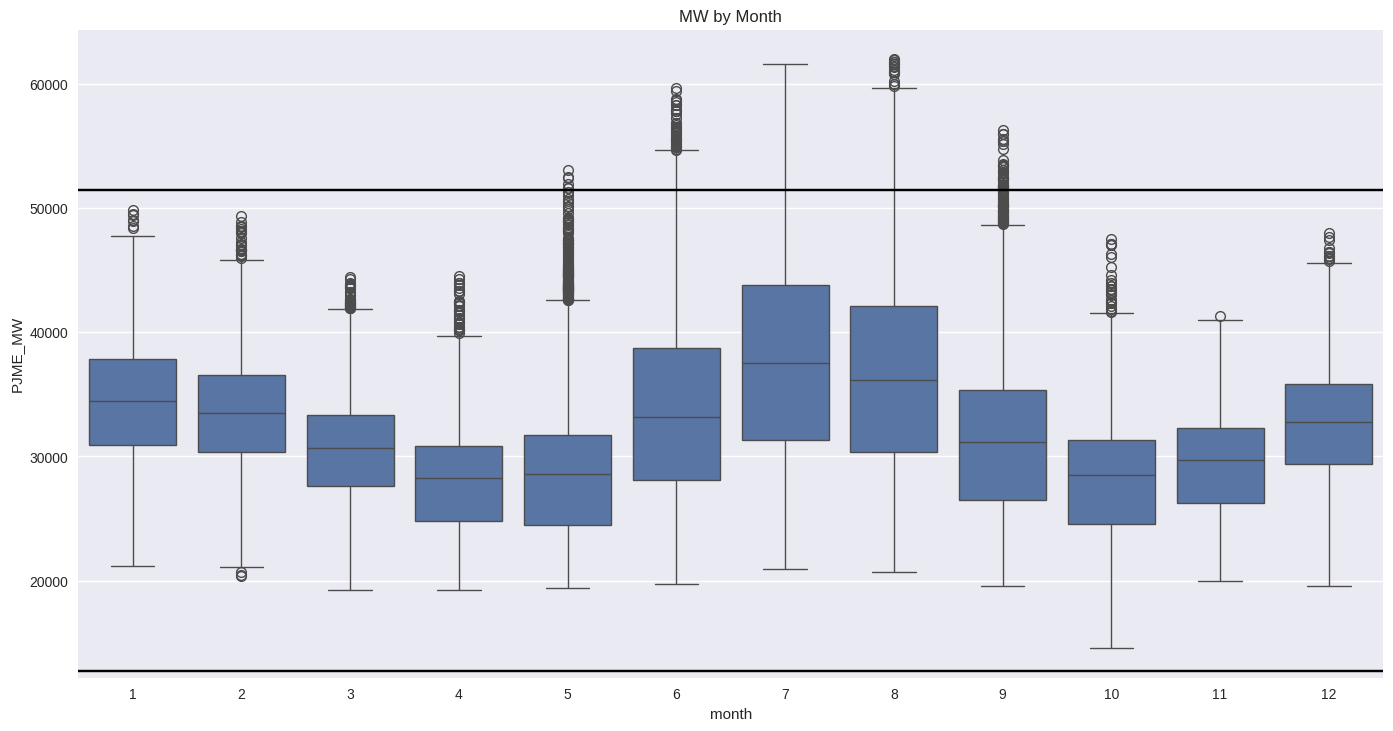

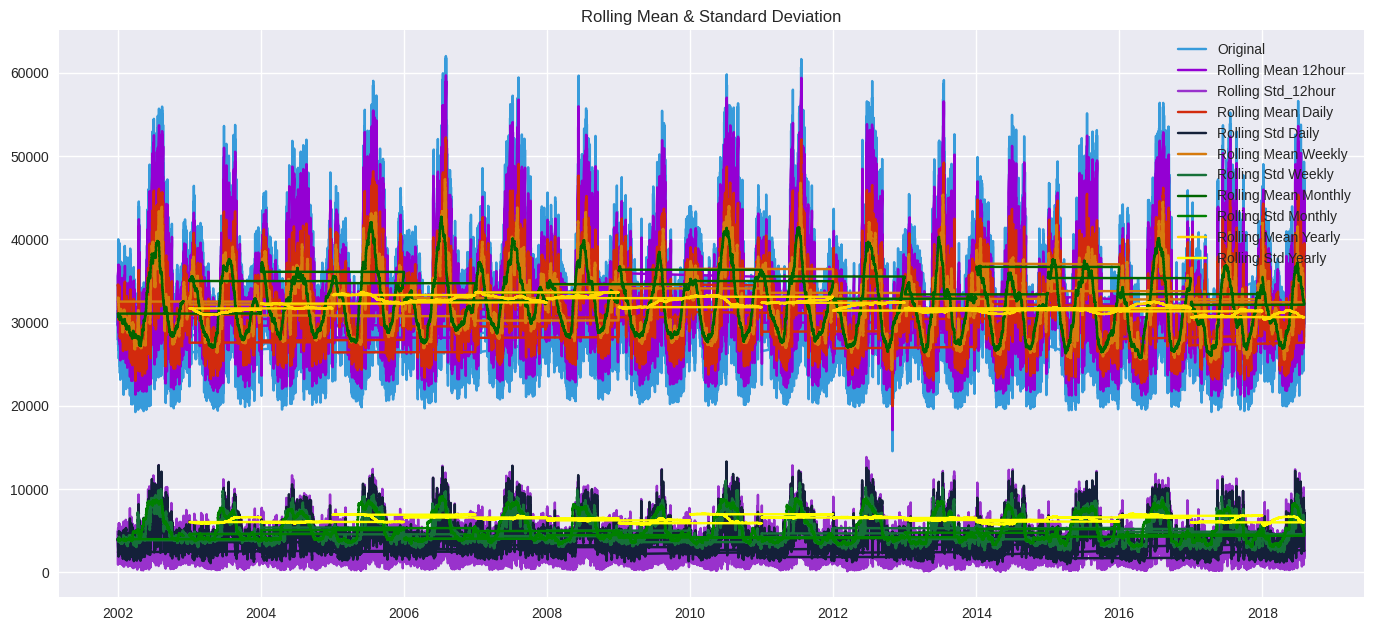

Results of Dickey Fuller Test:
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
#Lags Used                     7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64
time: 1min 37s (started: 2024-01-23 14:38:37 +00:00)


In [33]:
data_explore()

In [34]:
import timeit



time: 538 µs (started: 2024-01-23 14:40:15 +00:00)


#ProphetModel

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import timedelta
from sklearn.metrics import mean_squared_error

time: 788 µs (started: 2024-01-23 14:40:15 +00:00)


In [36]:
!pip install neuralprophet[live] --quiet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
set_random_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 17.3

In [37]:
def buildNeural(outlier, name):
   start_time = timeit.default_timer()
   nameset=name
   train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set=split_data(outlier)
   x = len(test_set)
   i=0
   while i < x:
    name=nameset
    pjme_train_prophet = train_set[i].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
    print(pjme_train_prophet.shape)
    pjme_test_prophet = test_set[i].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
    print( pjme_test_prophet.shape)
    model = NeuralProphet()
    metrics=model.fit(df=pjme_train_prophet, validation_df= pjme_test_prophet, freq="H", progress="plot-all")
    metrics[-1:]
    future = model.make_future_dataframe(df=pjme_train_prophet, periods=len(test_set[i]), n_historic_predictions=True)
    forecast = model.predict(df=future)
    fig_forecast = model.plot(forecast)



time: 1.08 ms (started: 2024-01-23 14:43:23 +00:00)


(8760, 2)
(8760, 2)


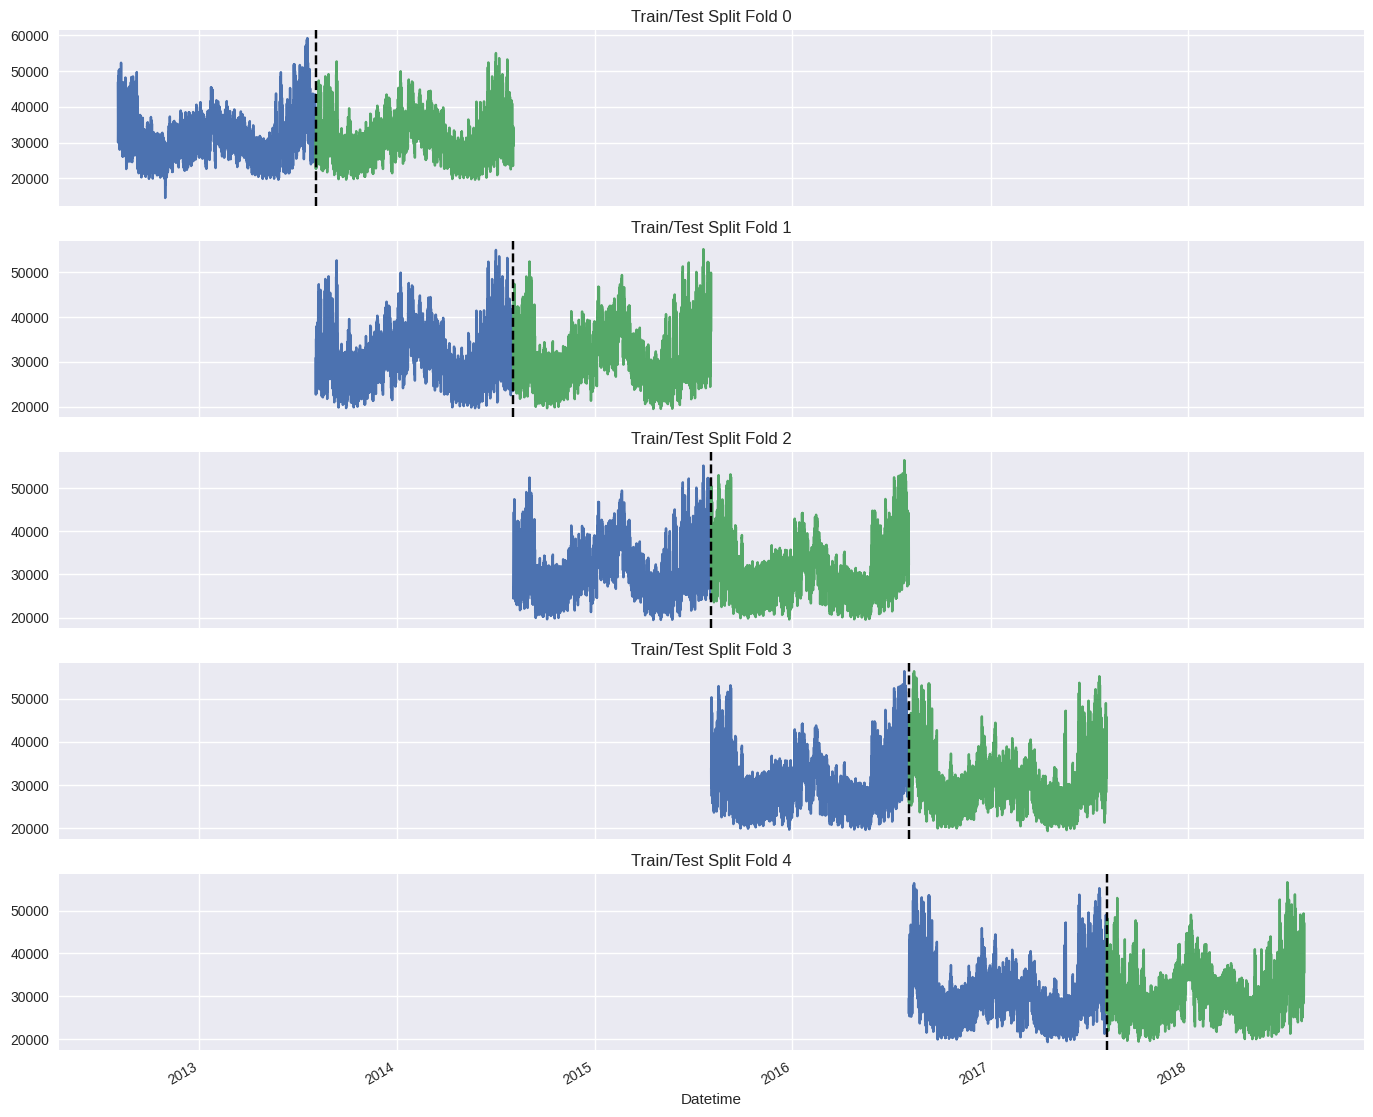

time: 9.56 s (started: 2024-01-23 14:43:23 +00:00)


In [38]:
train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set=split_data(False)
pjme_train_prophet = train_set[0].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
print(pjme_train_prophet.shape)
pjme_test_prophet = test_set[0].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
print(pjme_test_prophet.shape)


In [ ]:
# Parameter Options
param_grid = {
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
    'n_lags':[2,4],
    'newer_samples_weight':[2,4],
    'n_forecasts':[1,2],
    'learning_rate':[0.02, .04]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, epochs=10, batch_size=280)
    metrics4 = m.fit(df=pjme_train_prophet , validation_df=pjme_test_prophet , freq="H")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column y were auto-imputed.
INFO:NP.data.processing:2 NaN values in column y were auto-imputed.
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 missing dates added.
INFO:NP.data.processing:2 missing dates added.
WAR

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
m=buildNeural(False, "Neural")

In [ ]:
def buildProphet(outlier, name):
  start_time = timeit.default_timer()
  nameset=name
  train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set=split_data(outlier)

  x = len(test_set)
  i=0
  while i < x:
    name=nameset
  # Plot train and test so you can see where we have split
    test_set[i].rename(columns={'PJME_MW': 'TEST SET'}).join(train_set[i].rename(columns={'PJME_MW': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20, 8), title='PJM East', style='.', ms=1)
    plt.show()
  # Format data for prophet model using ds and y
    pjme_train_prophet = train_set[i].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
    print(pjme_train_prophet.shape)
    model = Prophet()
    model.fit(pjme_train_prophet)
  # Predict on test set with model
    pjme_test_prophet = test_set[i].reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

    pjme_test_fcst = model.predict(pjme_test_prophet)
    fig, ax = plt.subplots(figsize=(20, 16))
    fig = model.plot(pjme_test_fcst, ax=ax)
    ax.set_title('Prophet Forecast')
    fig.savefig('forecast.png')
    plt.show()
    fig = model.plot_components(pjme_test_fcst)
    fig.savefig('components.png')
    plt.show()
    # Plot the forecast with the actuals
    try: f
    except NameError: f = None
    if f is not None:
      del f
    try: ax
    except NameError: ax = None
    if ax is not None:
      del ax
    f, ax = plt.subplots(figsize=(24, 16))
    ax.scatter(test_set[i].index, test_set[i]['PJME_MW'], color='r')
    fig = model.plot(pjme_test_fcst, ax=ax)

    date_start = datetime.datetime(2015,1,1)
    date_end = test_set[i].index[-1]
    ax.set(xlim = [date_start,date_end])
    fig.savefig('compare.png')
    fig, ax = plt.subplots(figsize=(24, 12))

    ax.scatter(test_set[i].index, test_set[i]['PJME_MW'], color='r')

    fig = model.plot(pjme_test_fcst, ax=ax)
    ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('02-01-2015'))

    ax.set_ylim(0, 60000)

    plot = plt.suptitle('January 2015 Forecast vs Actuals')
    fig.savefig('comparemonth.png')
    # Plot the forecast with the actuals
    f, ax = plt.subplots(figsize=(24, 12))

    ax.scatter(test_set[i].index, test_set[i]['PJME_MW'], color='r')

    fig = model.plot(pjme_test_fcst, ax=ax)
    ax.set_xbound(lower=pd.to_datetime('01-01-2017'), upper=pd.to_datetime('01-08-2017'))
    ax.set_ylim(0, 60000)
    ax.set_title('First Week of January Forecast vs Actuals')
    fig.savefig('compareweek.png')

    plt.show()

    MSE,MAE,MAPE=modelcmp(test_set[i]['PJME_MW'],pjme_test_fcst['yhat'])
    name=name+str(i)
    elapsed = timeit.default_timer() - start_time

    new_row=[name,MSE,MAE,MAPE,elapsed]
    errorcmp.loc[len(errorcmp.index)]=new_row





    cal = calendar()
    holidays = cal.holidays(start=train_set[i].index.min(),
                        end=test_set[i].index.max(),
                        return_name=True)
    holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
    holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
    model_with_holidays = Prophet(holidays=holiday_df)
    model_with_holidays.fit(pjme_train_prophet)
    # Predict on training set with model
    pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)
    MSE,MAE,MAPE=modelcmp(test_set[i]['PJME_MW'],pjme_test_fcst_with_hols['yhat'])
    elapsed = timeit.default_timer() - start_time
    new_row=[name+'holiday',
          MSE,MAE,MAPE, elapsed]
    errorcmp.loc[len(errorcmp.index)]=new_row
    i=i+1
  return model, model_with_holidays

In [ ]:
model, model_with_holidays=buildProphet(False, 'ProphetOrig')



# Prophet - outliers

In [ ]:
model=buildProphet(True,'ProphetOrigNO')


In [ ]:
errorcmp

#XGBoost

In [ ]:
def xgbmodel(name, outlier=True):
  df= pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
  if outlier==True:
    df = df.loc[df['PJME_MW'] > 19500].copy()

  df, y = create_features(df, "PJME_MW")
  df["PJME_MW"]=y["PJME_MW"]
  df=add_lags(df)
  tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)
  df = df.sort_index()


  ##preprocess
  FEATURES = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']
  TARGET = ['PJME_MW']

  nameset=name
  start_time = timeit.default_timer()


  fold = 0
  preds = []
  scores = []

  for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    name=nameset
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor(base_score= 0.5, early_stopping_rounds= 25, learning_rate= 0.07, max_depth= 4, n_estimators= 100)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    name=name+str(fold)
    tryme=pd.DataFrame()
    data={'PJME_MW':y_test["PJME_MW"],'predictions':reg.predict(X_test)}
    tryme= pd.DataFrame(data,index=y_test.index)
    MSE,MAE,MAPE=modelcmp(tryme["PJME_MW"],tryme["predictions"])
    elapsed = timeit.default_timer() - start_time
    new_row=[name,
            MSE,MAE,MAPE,elapsed]
    errorcmp.loc[len(errorcmp.index)]=new_row
    fold=fold+1
    y_train['PJME_MW'].plot(style='k', figsize=(10,5), label = 'train')
    tryme['PJME_MW'].plot(style='b', figsize=(10,5), label = 'test')
    tryme['predictions'].plot(style='r', figsize=(10,5), label = 'prediction')
    plt.title('MW PReds')
    plt.legend()
    plt.show()


  print(f'Score across folds {np.mean(scores):0.4f}')
  print(f'Fold scores:{scores}')
  print('Average score:', sum(scores)/len(scores))
  fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
  fi.sort_values('importance').plot(kind='barh', title='Feature Importance')


  plt.show()



  return reg


In [ ]:
model2=xgbmodel('xgboost.01 bias.5', params)


In [ ]:
errorcmp

#SARIMA


In [ ]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])
def plot_forecasts(y_train, y_test, forecasts, title, figsize=(8, 12)):
    x = np.arange(y_train.shape[0] + forecasts.shape[0])

    fig, axes = plt.subplots(2, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes[0].plot(x[:y_train.shape[0]], y_train, c='b')
    axes[0].plot(x[y_train.shape[0]:], forecasts, c='g')
    axes[0].set_xlabel(f'Sunspots (RMSE={np.sqrt(mse(y_test, forecasts)):.3f})')
    axes[0].set_title(title)

    # Plot the residuals
    resid = y_test - forecasts
    _, p = normaltest(resid)
    axes[1].hist(resid, bins=15)
    axes[1].axvline(0, linestyle='--', c='r')
    axes[1].set_title(f'Residuals (p={p:.3f})')

    plt.tight_layout()
    plt.show()

def Sarima_model(period, outlier=False):
    start_time=timeit.default_timer()
    train_set, test_set, train_x_set, train_y_set, test_x_set, test_y_set=split_data(outlier)

    x=len(train_set)
    i=0
    name="SARIMA Period="+str(period)+"Train_set="+str(i)
    while i<x:

      fit = pm.auto_arima(train_y_set[i], m=period, trace=True, suppress_warnings=True)
      normaltest(train_y_set[i])[1]
      model=fit
      forecasts = []
      confidence_intervals = []
      for new_ob in test_y_set[i]["PJME_MW"]:
        fc, conf = forecast_one_step()
        forecasts.append(fc)
        confidence_intervals.append(conf)
        model.update(new_ob)
      plot_forecasts(train_y_set[i],test_y_set[i], forecasts, name)
      MSE,MAE,MAPE=modelcmp(test_y_set[i], forecasts)
      elapsed = timeit.default_timer() - start_time
      new_row=[name,MSE,MAE,MAPE,elapsed]
      errorcmp.loc[len(errorcmp.index)]=new_row



In [ ]:
df= pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pm.plot_acf(df)
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df)  # (0.01, False)
print(should_diff, p_val)
train, test = df[:150], df[150:]
m1 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=1)
m12 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=12)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=1
axes[0].scatter(x, test, marker='x')
axes[0].plot(x, m1.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')

# Plot m=12
axes[1].scatter(x, test, marker='x')
axes[1].plot(x, m12.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=12)')

plt.show()


In [ ]:
m12 = pm.auto_arima(train, error_action='ignore', seasonal=True, m=24)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=1
axes[0].scatter(x, test, marker='x')
axes[0].plot(x, m1.predict(n_periods=test.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')

# Plot m=12
axes[1].scatter(x, test, marker='x')
axes[1].plot(x, m12.predict(n_periods=test.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=12)')

plt.show()


In [ ]:
from matplotlib import pyplot


In [ ]:
from pandas.plotting import autocorrelation_plot
df= pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
autocorrelation_plot(df)
pyplot.show()

In [ ]:

Sarima_model(1)
Sarima_model(24)
Sarima_model(168)




In [ ]:
# Mean squared error: 0.34238951346274243
# SMAPE: 0.9825490519101439

#Arima

In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
%pip install pmdarima --quiet
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

df=pd.read_csv('PowerUpProject/data/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
df = df.sort_index()
df.head(3)

In [ ]:
df[["PJME_MW"]].plot(subplots=True, layout=(2,1));

In [ ]:
#Test for stationarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(365).mean()
    rolstd = timeseries.rolling(365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df)

In [ ]:
#split data into train and training set
#TODO try hardcoding the split
from sklearn.model_selection import TimeSeriesSplit

#tscv = TimeSeriesSplit(n_splits=2, gap=20)
train_data=df.loc['2010-01-01':'2014-01-01']
test_data=df.loc['2014-01-05':'2016-01-01']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Power Usage (MW)')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,            # frequency of series
                      d=1,              # Override d
                      seasonal=True,    # Yes Seasonality
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(train_data, order=(3, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
pd = model_fit.predict(start=0, end=0)

In [ ]:
pd = model_fit.get_prediction(steps=len(test_data), alpha=0.05)
print(pd.summary_frame())
plt.plot(pd.predicted_mean)

In [ ]:
forecast = model_fit.get_forecast(len(test_data), alpha=0.05)  # 95% confidence
forecast.predicted_mean
plt.plot(forecast.predicted_mean)

In [ ]:
# Forecast
fc = model_fit.get_forecast(len(test_data), alpha=0.05)  # 95% confidence
test_data_frame = pd.DataFrame(test_data)
fc_data_frame = pd.DataFrame(fc.predicted_mean)
fc_data_frame.index = test_data_frame.index
# fc_series = pd.Series(fc_data_frame)
lower_series = pd.Series(fc.conf_int()['lower PJME_MW'], index=test_data.index)
upper_series = pd.Series(fc.conf_int()['upper PJME_MW'], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Power Usage')
plt.plot(fc_data_frame, color = 'orange', label='Predicted Power Usage')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('PJME Power Usage')
plt.xlabel('Time')
plt.ylabel('Actual Power Usage (MW)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['PJME_MW'].tail(600), color='green', label = 'Train Power Usage')
plt.plot(test_data.index, y, color = 'red', label = 'Real Power Usage')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Power Usage')
plt.title('PJME Power Usage')
plt.xlabel('Time')
plt.ylabel('Power Usage (MW)')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

##FUCKAROUND


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)


from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [ ]:
df=df=pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
df=df.sort_index()

In [ ]:
df.fillna(df.mean(numeric_only=True).round(1), inplace=True)
df.shape

In [ ]:
datetimeindex=pd.date_range('2002-01-01 01:00:00', periods=145366, tz='Australia/Adelaide', freq='H')

In [ ]:
df.index=datetimeindex

In [ ]:
train_data=df.loc['2010-01-01':'2014-01-01']
test_data=df.loc['2014-01-05':'2016-01-01']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Power Usage (MW)')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
plt.figure(figsize=(15,7))
plt.title("PJME_MW")
plt.xlabel('Date')
plt.ylabel('MW')
plt.plot(df)
plt.show()

In [ ]:
#Determine rolling statistics
train_data["rolling_avg"] = train_data["PJME_MW"].rolling(window=168).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
train_data["rolling_std"] = train_data["PJME_MW"].rolling(window=168).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(train_data["PJME_MW"], color='#379BDB', label='Original')
plt.plot(train_data["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(train_data["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(train_data['PJME_MW'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
def newmodel(df, name, rate, bias):
  tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)
  df = df.sort_index() # df needs to be sorted for TimeSeriesSplit
  ig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)

  fold = 0
  for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axes[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}')

    test['PJME_MW'].plot(ax=axes[fold],
                         label='Test Set')

    axes[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

  fold = 0

  preds = []
  scores = []

  for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor(base_score=bias, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=rate)
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
  print(f'Score across folds {np.mean(scores):0.4f}')
  print(f'Fold scores:{scores}')
  print('Average score:', sum(scores)/len(scores))
  fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
  fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
  plt.show()

  test['prediction'] = reg.predict(X_test)
  df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
  ax = df[['PJME_MW']].plot(figsize=(15, 5))
  df['prediction'].plot(ax=ax, style='-')
  plt.legend(['Truth Data', 'Predictions'])
  ax.set_title('Raw Dat and Prediction')
  plt.show()

  ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
  df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
  plt.legend(['Truth Data','Prediction'])
  plt.show()
  MSE,MAE,MAPE=modelcmp(test['PJME_MW'],test['prediction'])
  new_row=[name,
          MSE,MAE,MAPE]
  errorcmp.loc[len(errorcmp.index)]=new_row


  from sklearn.model_selection import GridSearchCV

  return reg

In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(train_data['PJME_MW'],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
def forecast(ARIMA_model, periods=17472):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train_data.index[-1] + pd.DateOffset(months=0), periods = n_periods, freq='H')
    print(fitted)
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["PJME_MW"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of MW")
    plt.show()

forecast(ARIMA_model)

In [ ]:
SARIMA_model = pm.auto_arima(df["PJME_MW"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=168, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()


In [ ]:
forecast(SARIMA_model)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df['PJME_MW'], order=(3,0,1), simple_differencing=True)
res = mod.fit(disp=False)


In [ ]:
df['lnMW']=np.log(df['PJME_MW'])

In [ ]:
mod2 = sm.tsa.statespace.SARIMAX(df['lnMW'], order=(3,0,1), simple_differencing=True)
res2 = mod.fit(disp=False)

In [ ]:
print(res2.summary())
